## MCMC_Event Detection Visualization with SQLite

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from datetime import timedelta
from ipywidgets import interact, Dropdown

In [32]:
# ==== Load your original dataset ====
# Load your saved data
original_data = pd.read_excel('/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master-copy/input_data/summer_data.xlsx', index_col='DateTime') 

# ==== Load detected events ====
sig_events_mcmc = pd.read_excel('/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master-copy/simulations/test_results/mcmc_significant_events.xlsx', index_col=0)
stat_events_mcmc = pd.read_excel('/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master-copy/simulations/test_results/mcmc_stationary_events.xlsx', index_col=0)

In [33]:
sig_events_mcmc = sig_events_mcmc.reset_index()
stat_events_mcmc = stat_events_mcmc.reset_index()

In [34]:
print("Significant Events Columns:", sig_events_mcmc.columns.tolist())
print("Stationary Events Columns:", stat_events_mcmc.columns.tolist())

Significant Events Columns: ['t1', 't2', '∆t_m', 'w_m(t1)', 'w_m(t2)', '∆w_m', 'σ_m', 'θ_m']
Stationary Events Columns: ['t1', 't2', '∆t_s', 'σ_s']


### Plot for 1 hour

In [35]:
def plot_rba_theta_grid(
    original_data,
    sig_events_mcmc,
    stat_events_mcmc,
    start_time_str,
    duration_hours=1,
    save_path="rba_theta_grid.png"
):
    # Load original data (normalized)
    df = pd.read_excel(original_data_path, index_col='DateTime', parse_dates=True)

    # Load MCMC detected events
    significant_df = pd.read_excel(sig_event_path, index_col=0)
    stationary_df = pd.read_excel(stat_event_path, index_col=0)

    # Setup time window
    start_time = pd.to_datetime(start_time_str)
    end_time = start_time + timedelta(hours=duration_hours)

    # Setup subplots: auto-arranged for number of turbines
    turbine_names = df.columns[:8]  # first 8 turbines or fewer
    n_turbines = len(turbine_names)
    ncols = 4
    nrows = (n_turbines + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3.5 * nrows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, turbine in enumerate(turbine_names):
        ax = axes[i]
        df_window = df[turbine].loc[start_time:end_time]
        ax.plot(df_window.index, df_window.values, color='blue', label='Original data')

        # Significant (ramp) events
        if turbine in significant_df.index:
            sub_sig = significant_df.loc[[turbine]]
            for _, row in sub_sig.iterrows():
                t1, t2 = int(row['t1']), int(row['t2'])
                if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
                    t1_time = df.iloc[t1].name
                    t2_time = df.iloc[t2].name
                    if t1_time > end_time or t2_time < start_time:
                        continue
                    segment = df[turbine].loc[t1_time:t2_time]
                    if not segment.empty:
                        color = 'red' if row['∆w_m'] > 0 else 'cyan'
                        ax.plot(segment.index, segment.values, color=color, linewidth=2)

        # Stationary events
        if turbine in stationary_df.index:
            sub_stat = stationary_df.loc[[turbine]]
            for _, row in sub_stat.iterrows():
                t1, t2 = int(row['t1']), int(row['t2'])
                if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
                    t1_time = df.iloc[t1].name
                    t2_time = df.iloc[t2].name
                    if t1_time > end_time or t2_time < start_time:
                        continue
                    ax.axvspan(t1_time, t2_time, color='gray', alpha=0.3)

        ax.set_title(turbine)
        ax.set_ylim(0, 1.05)
        ax.grid(True)
        ax.set_xticks(pd.date_range(start=start_time, end=end_time, periods=5))
        ax.tick_params(axis='x', rotation=45)

    # Remove unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # Global axis labels and legend
    fig.text(0.5, 0.04, "Time [hours]", ha='center', fontsize=12)
    fig.text(0.04, 0.5, "Wind power generation [per unit]", va='center', rotation='vertical', fontsize=12)

    # Legend
    handles = [
        mpatches.Patch(color='blue', label='Original data'),
        mpatches.Patch(color='red', label='Up-ramp events'),
        mpatches.Patch(color='cyan', label='Down-ramp events'),
        mpatches.Patch(color='gray', alpha=0.3, label='Stationary events'),
    ]
    fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
    plt.savefig(save_path, dpi=300)
    plt.show()

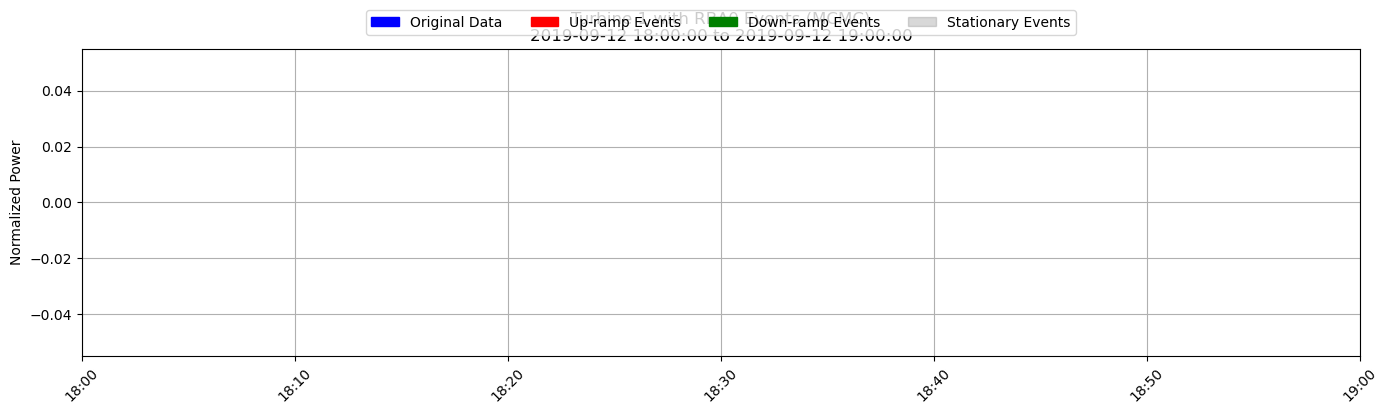

In [6]:
# === Turbine setup ===
turbine_col = df.columns[0]
sub_sig = significant_df.copy()
sub_stat = stationary_df.copy()

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_1h.index, df_1h[turbine_col], color='blue', marker='o', label='Original Data')

# === Overlay significant events ===
if 't1' not in sub_sig.columns:
    sub_sig.reset_index(inplace=True)

for _, row in sub_sig.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            segment = df[turbine_col].loc[t1_time:t2_time]
            if not segment.empty:
                color = 'red' if row['∆w_m'] > 0 else 'green'
                ax.plot(segment.index, segment.values, color=color, linewidth=2)

# === Overlay stationary events ===
if 't1' not in sub_stat.columns:
    sub_stat.reset_index(inplace=True)

for _, row in sub_stat.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            ax.axvspan(t1_time, t2_time, color='gray', alpha=0.3)

# === Labels and formatting ===
ax.set_title(f"Turbine 1 with RBAθ Events (MCMC)\n{start_time} to {end_time}")
ax.set_ylabel("Normalized Power")
ax.set_xlim(start_time, end_time)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.grid(True)

patches = [
    mpatches.Patch(color='blue', label='Original Data'),
    mpatches.Patch(color='red', label='Up-ramp Events'),
    mpatches.Patch(color='green', label='Down-ramp Events'),
    mpatches.Patch(color='gray', alpha=0.3, label='Stationary Events'),
]
ax.legend(handles=patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Plot for 24 hours

In [7]:
# === Choose a 24-hour time window ===
start_time = pd.to_datetime("2019-09-01 01:00:00")  # change date as needed
end_time = start_time + pd.Timedelta(hours=24)
df_24h = df.loc[start_time:end_time]

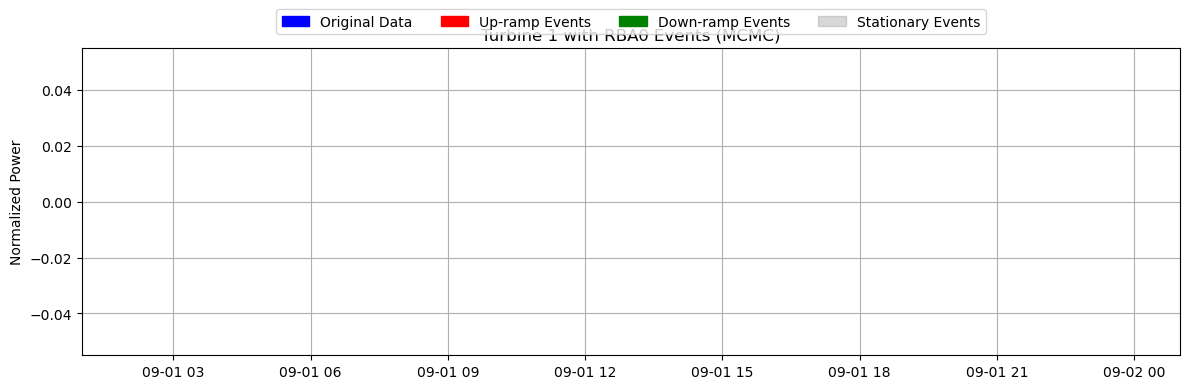

In [8]:
# === Plot for Turbine 1 ===
turbine_col = df.columns[0]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_24h.index, df_24h[turbine_col], color='blue', label='Original Data')

# === Get turbine name from event index ===
turbine_name = significant_df.index.unique()[0]

# === Overlay significant events (up/down ramp) ===
if turbine_name in significant_df.index:
    sub_sig = significant_df.loc[[turbine_name]]
    if isinstance(sub_sig, pd.Series):
        sub_sig = pd.DataFrame([sub_sig])
    if 't1' not in sub_sig.columns:
        sub_sig.reset_index(inplace=True)

    for _, row in sub_sig.iterrows():
        t1, t2 = int(row['t1']), int(row['t2'])
        if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
            t1_time, t2_time = df.index[t1], df.index[t2]
            if start_time <= t1_time <= end_time:
                segment = df[turbine_col].loc[t1_time:t2_time]
                if not segment.empty:
                    color = 'red' if row['∆w_m'] > 0 else 'green'
                    ax.plot(segment.index, segment.values, color=color, linewidth=2)

# === Overlay stationary events ===
if turbine_name in stationary_df.index:
    sub_stat = stationary_df.loc[[turbine_name]]
    if isinstance(sub_stat, pd.Series):
        sub_stat = pd.DataFrame([sub_stat])
    if 't1' not in sub_stat.columns:
        sub_stat.reset_index(inplace=True)

    for _, row in sub_stat.iterrows():
        t1, t2 = int(row['t1']), int(row['t2'])
        if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
            t1_time, t2_time = df.index[t1], df.index[t2]
            if start_time <= t1_time <= end_time:
                ax.axvspan(t1_time, t2_time, color='gray', alpha=0.3)

# === Labels, legend, and save ===
ax.set_title("Turbine 1 with RBAθ Events (MCMC)")
ax.set_ylabel("Normalized Power")
ax.set_xlim(start_time, end_time)
ax.grid(True)

patches = [
    mpatches.Patch(color='blue', label='Original Data'),
    mpatches.Patch(color='red', label='Up-ramp Events'),
    mpatches.Patch(color='green', label='Down-ramp Events'),
    mpatches.Patch(color='gray', alpha=0.3, label='Stationary Events'),
]
ax.legend(handles=patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
# Use date in filename for traceability
output_filename = f"Turbine1_RBATheta_MCMC_{start_time.date()}.png"
plt.savefig(output_filename, dpi=300)
plt.show()

### Plot for Monthly (adjustable) visualization

In [40]:
# === Choose the range (1 month or 4 months) ===
start_time = pd.to_datetime("2019-09-01")
duration = pd.DateOffset(months=1) 
end_time = start_time + duration
df_range = df.loc[start_time:end_time]

In [41]:
# === Turbine setup ===
turbine_col = df.columns[0]
turbine_name = significant_df.index.unique()[0]


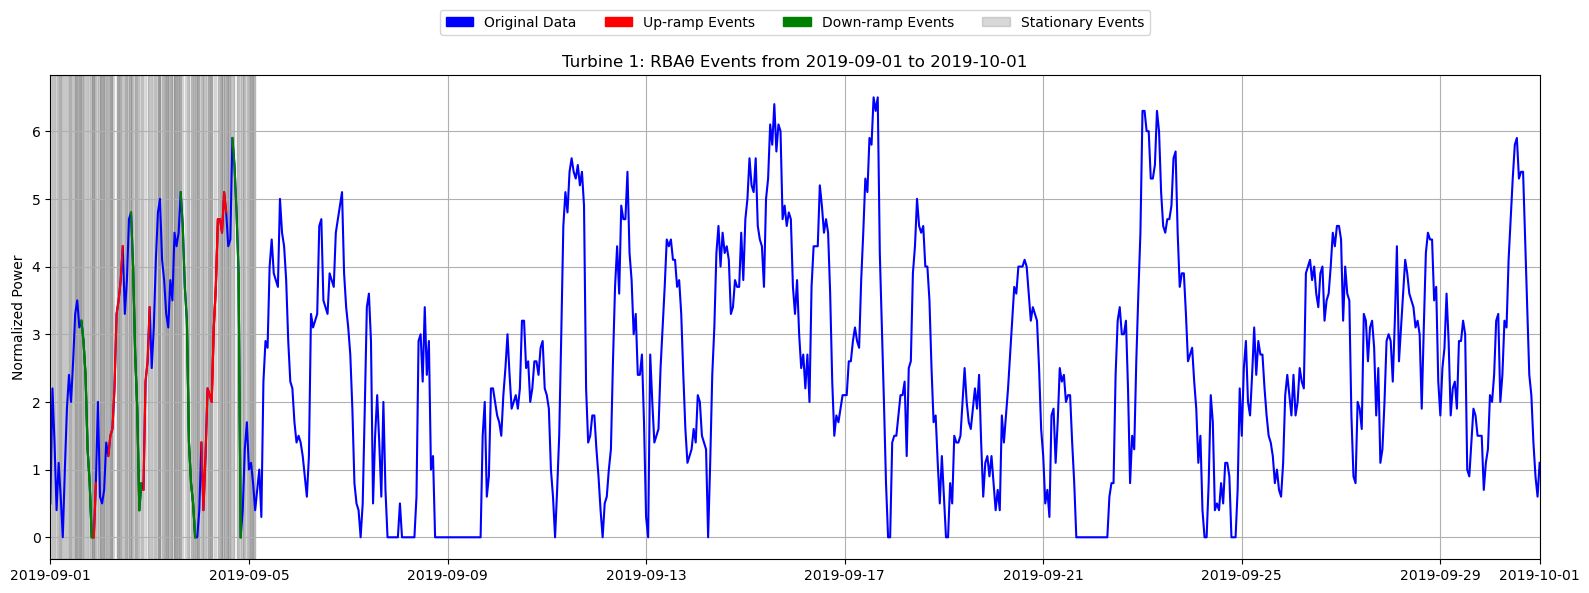

In [42]:
# === Plot full-range visualization ===
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_range.index, df_range[turbine_col], color='blue', label='Original Data')

# === Plot significant events ===
sub_sig = significant_df.copy()
if isinstance(sub_sig, pd.Series):
    sub_sig = pd.DataFrame([sub_sig])
if 't1' not in sub_sig.columns:
    sub_sig.reset_index(inplace=True)

for _, row in sub_sig.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            segment = df[turbine_col].loc[t1_time:t2_time]
            if not segment.empty:
                color = 'red' if row['∆w_m'] > 0 else 'green'
                ax.plot(segment.index, segment.values, color=color, linewidth=1.5)

# === Plot stationary events ===
sub_stat = stationary_df.copy()
if isinstance(sub_stat, pd.Series):
    sub_stat = pd.DataFrame([sub_stat])
if 't1' not in sub_stat.columns:
    sub_stat.reset_index(inplace=True)

for _, row in sub_stat.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            ax.axvspan(t1_time, t2_time, color='gray', alpha=0.25)

# === Final touches ===
ax.set_title(f"Turbine 1: RBAθ Events from {start_time.date()} to {end_time.date()}")
ax.set_ylabel("Normalized Power")
ax.set_xlim(start_time, end_time)
ax.grid(True)

patches = [
    mpatches.Patch(color='blue', label='Original Data'),
    mpatches.Patch(color='red', label='Up-ramp Events'),
    mpatches.Patch(color='green', label='Down-ramp Events'),
    mpatches.Patch(color='gray', alpha=0.3, label='Stationary Events'),
]
ax.legend(handles=patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.show()

### 5/6 days of visualization

In [35]:
# === Choose the range (1 month or 4 months) ===
start_time = pd.to_datetime("2019-09-01")
duration = pd.DateOffset(days=6) 
end_time = start_time + duration
df_range = df.loc[start_time:end_time]

# === Turbine setup ===
turbine_col = df.columns[0]
turbine_name = significant_df.index.unique()[0]

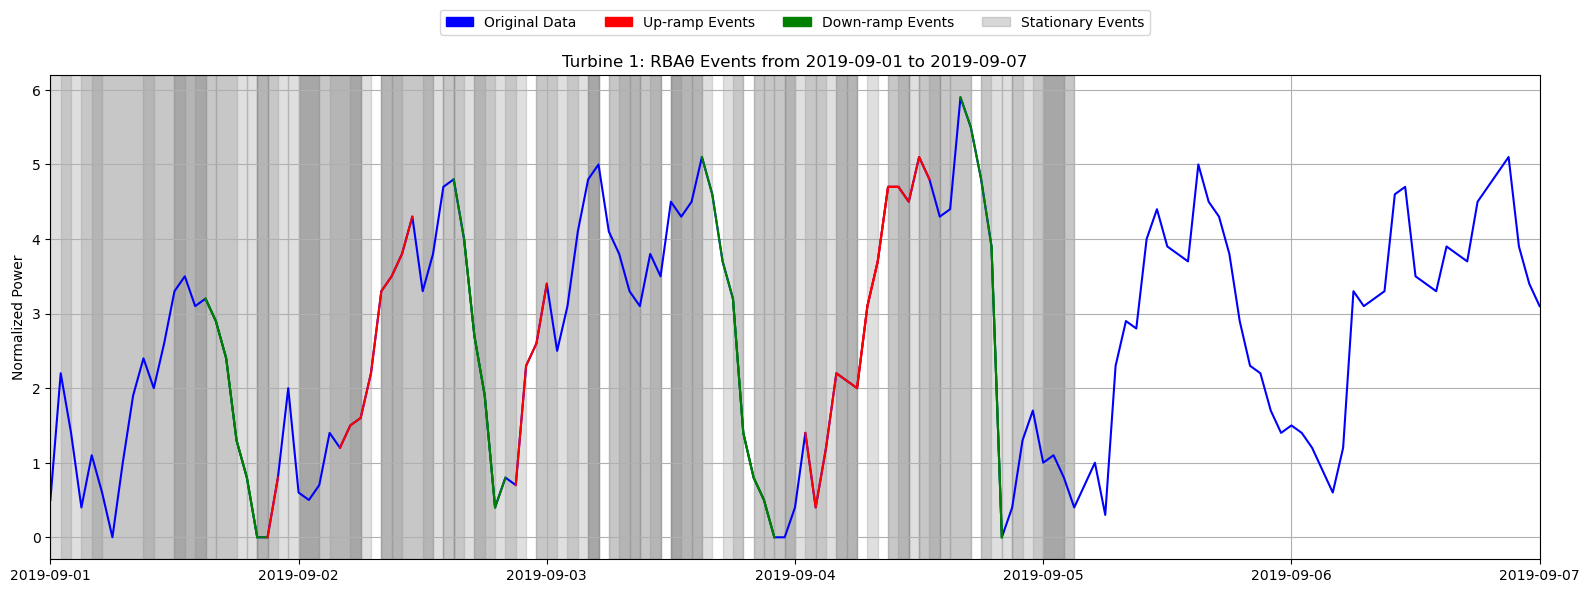

In [36]:
# === Plot full-range visualization ===
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_range.index, df_range[turbine_col], color='blue', label='Original Data')

# === Plot significant events ===
sub_sig = significant_df.copy()
if isinstance(sub_sig, pd.Series):
    sub_sig = pd.DataFrame([sub_sig])
if 't1' not in sub_sig.columns:
    sub_sig.reset_index(inplace=True)

for _, row in sub_sig.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            segment = df[turbine_col].loc[t1_time:t2_time]
            if not segment.empty:
                color = 'red' if row['∆w_m'] > 0 else 'green'
                ax.plot(segment.index, segment.values, color=color, linewidth=1.5)

# === Plot stationary events ===
sub_stat = stationary_df.copy()
if isinstance(sub_stat, pd.Series):
    sub_stat = pd.DataFrame([sub_stat])
if 't1' not in sub_stat.columns:
    sub_stat.reset_index(inplace=True)

for _, row in sub_stat.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            ax.axvspan(t1_time, t2_time, color='gray', alpha=0.25)

# === Final touches ===
ax.set_title(f"Turbine 1: RBAθ Events from {start_time.date()} to {end_time.date()}")
ax.set_ylabel("Normalized Power")
ax.set_xlim(start_time, end_time)
ax.grid(True)

patches = [
    mpatches.Patch(color='blue', label='Original Data'),
    mpatches.Patch(color='red', label='Up-ramp Events'),
    mpatches.Patch(color='green', label='Down-ramp Events'),
    mpatches.Patch(color='gray', alpha=0.3, label='Stationary Events'),
]
ax.legend(handles=patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.show()

## Traditional_event detection visualization

### 1 hour timeframe

In [14]:
# ==== Load your original dataset ====
df = pd.read_excel("/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master/input_data/fall_data.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# ==== Load detected events ====
significant_df = pd.read_excel("/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master/simulations/test_results/traditional_significant_events.xlsx", header=0, index_col=0)
stationary_df = pd.read_excel("/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master/simulations/test_results/traditional_stationary_events.xlsx", header=0, index_col=0)

In [15]:
# === Set 1-hour time window (customize this) ===
start_time = pd.to_datetime("2019-09-12 18:00:00")  # change this to shift the hour
end_time = start_time + pd.Timedelta(hours=1)
df_1h = df.loc[start_time:end_time]

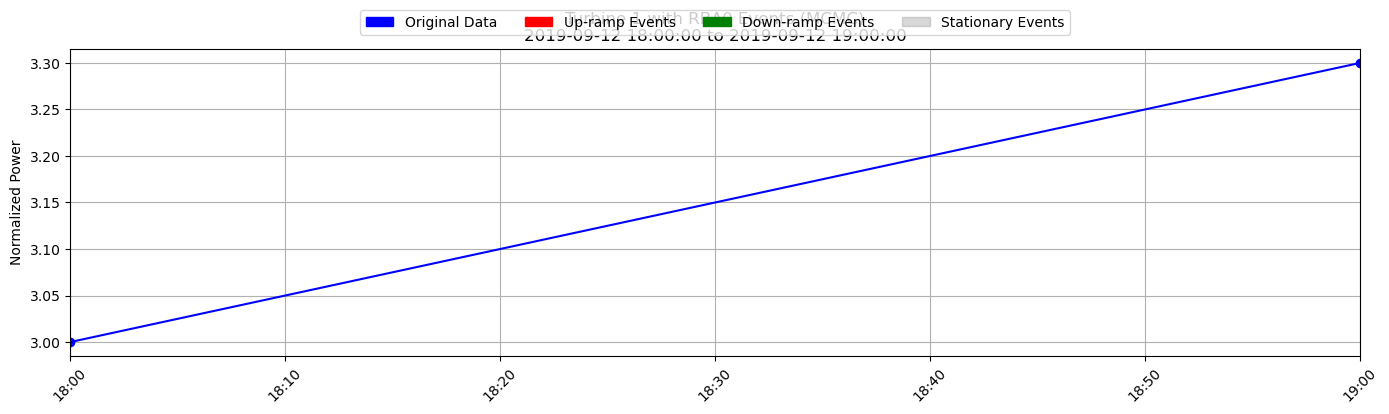

In [16]:
# === Turbine setup ===
turbine_col = df.columns[0]
sub_sig = significant_df.copy()
sub_stat = stationary_df.copy()

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_1h.index, df_1h[turbine_col], color='blue', marker='o', label='Original Data')

# === Overlay significant events ===
if 't1' not in sub_sig.columns:
    sub_sig.reset_index(inplace=True)

for _, row in sub_sig.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            segment = df[turbine_col].loc[t1_time:t2_time]
            if not segment.empty:
                color = 'red' if row['∆w_m'] > 0 else 'green'
                ax.plot(segment.index, segment.values, color=color, linewidth=2)

# === Overlay stationary events ===
if 't1' not in sub_stat.columns:
    sub_stat.reset_index(inplace=True)

for _, row in sub_stat.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            ax.axvspan(t1_time, t2_time, color='gray', alpha=0.3)

# === Labels and formatting ===
ax.set_title(f"Turbine 1 with RBAθ Events (MCMC)\n{start_time} to {end_time}")
ax.set_ylabel("Normalized Power")
ax.set_xlim(start_time, end_time)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.grid(True)

patches = [
    mpatches.Patch(color='blue', label='Original Data'),
    mpatches.Patch(color='red', label='Up-ramp Events'),
    mpatches.Patch(color='green', label='Down-ramp Events'),
    mpatches.Patch(color='gray', alpha=0.3, label='Stationary Events'),
]
ax.legend(handles=patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### 24 hours timeframe

In [29]:
# === Choose a 24-hour time window ===
start_time = pd.to_datetime("2019-09-01 01:00:00")  # change date as needed
end_time = start_time + pd.Timedelta(hours=24)
df_24h = df.loc[start_time:end_time]

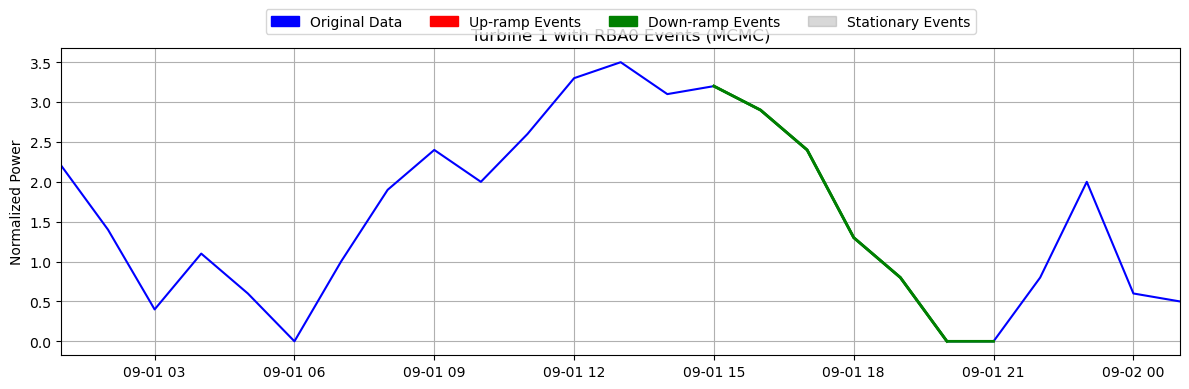

In [30]:
# === Plot for Turbine 1 ===
turbine_col = df.columns[0]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_24h.index, df_24h[turbine_col], color='blue', label='Original Data')

# === Get turbine name from event index ===
turbine_name = significant_df.index.unique()[0]

# === Overlay significant events (up/down ramp) ===
if turbine_name in significant_df.index:
    sub_sig = significant_df.loc[[turbine_name]]
    if isinstance(sub_sig, pd.Series):
        sub_sig = pd.DataFrame([sub_sig])
    if 't1' not in sub_sig.columns:
        sub_sig.reset_index(inplace=True)

    for _, row in sub_sig.iterrows():
        t1, t2 = int(row['t1']), int(row['t2'])
        if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
            t1_time, t2_time = df.index[t1], df.index[t2]
            if start_time <= t1_time <= end_time:
                segment = df[turbine_col].loc[t1_time:t2_time]
                if not segment.empty:
                    color = 'red' if row['∆w_m'] > 0 else 'green'
                    ax.plot(segment.index, segment.values, color=color, linewidth=2)

# === Overlay stationary events ===
if turbine_name in stationary_df.index:
    sub_stat = stationary_df.loc[[turbine_name]]
    if isinstance(sub_stat, pd.Series):
        sub_stat = pd.DataFrame([sub_stat])
    if 't1' not in sub_stat.columns:
        sub_stat.reset_index(inplace=True)

    for _, row in sub_stat.iterrows():
        t1, t2 = int(row['t1']), int(row['t2'])
        if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
            t1_time, t2_time = df.index[t1], df.index[t2]
            if start_time <= t1_time <= end_time:
                ax.axvspan(t1_time, t2_time, color='gray', alpha=0.3)

# === Labels, legend, and save ===
ax.set_title("Turbine 1 with RBAθ Events (MCMC)")
ax.set_ylabel("Normalized Power")
ax.set_xlim(start_time, end_time)
ax.grid(True)

patches = [
    mpatches.Patch(color='blue', label='Original Data'),
    mpatches.Patch(color='red', label='Up-ramp Events'),
    mpatches.Patch(color='green', label='Down-ramp Events'),
    mpatches.Patch(color='gray', alpha=0.3, label='Stationary Events'),
]
ax.legend(handles=patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
# Use date in filename for traceability
output_filename = f"Turbine1_RBATheta_Traditional_{start_time.date()}.png"
plt.savefig(output_filename, dpi=300)
plt.show()

### Monthly timeframe (Can be converted into day just by changing: duration = pd.DateOffset(days=3) )

In [25]:
# === Choose the range (1 month or 4 months) ===
start_time = pd.to_datetime("2019-09-01")
duration = pd.DateOffset(days=6) 
end_time = start_time + duration
df_range = df.loc[start_time:end_time]

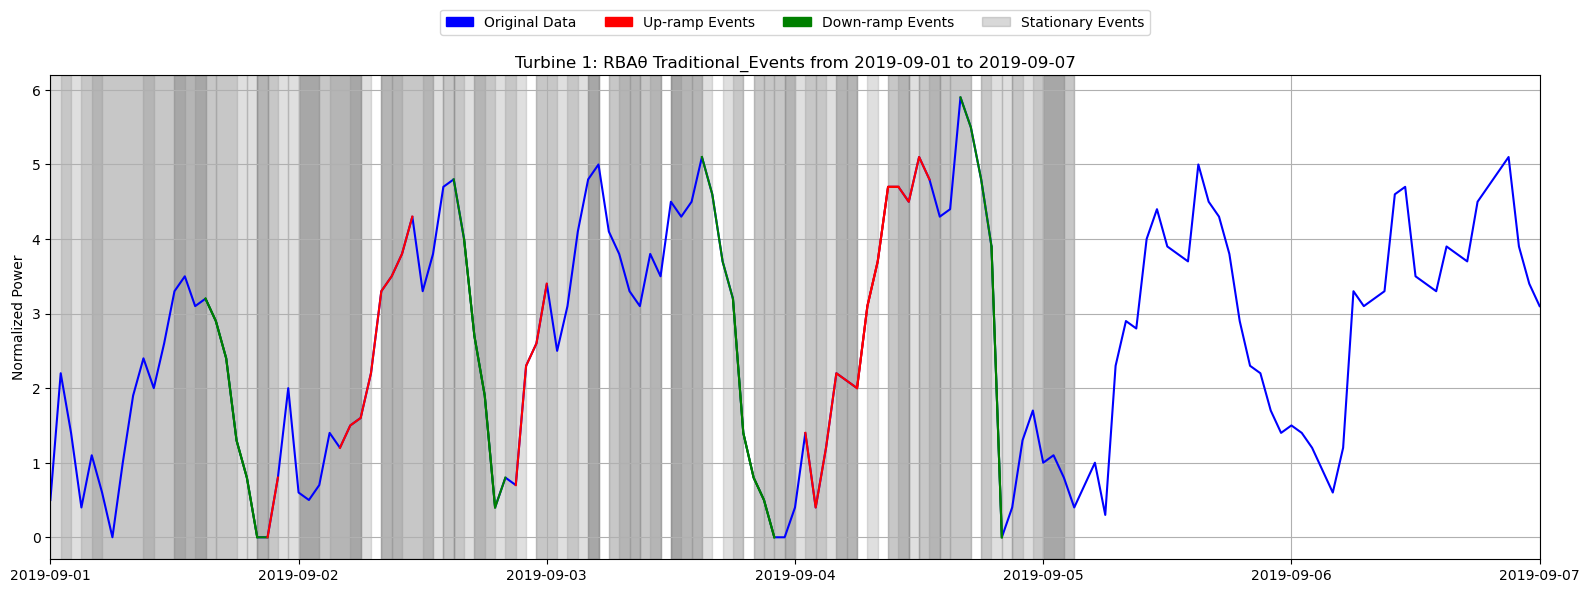

In [26]:
# === Plot full-range visualization ===
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_range.index, df_range[turbine_col], color='blue', label='Original Data')

# === Plot significant events ===
sub_sig = significant_df.copy()
if isinstance(sub_sig, pd.Series):
    sub_sig = pd.DataFrame([sub_sig])
if 't1' not in sub_sig.columns:
    sub_sig.reset_index(inplace=True)

for _, row in sub_sig.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            segment = df[turbine_col].loc[t1_time:t2_time]
            if not segment.empty:
                color = 'red' if row['∆w_m'] > 0 else 'green'
                ax.plot(segment.index, segment.values, color=color, linewidth=1.5)

# === Plot stationary events ===
sub_stat = stationary_df.copy()
if isinstance(sub_stat, pd.Series):
    sub_stat = pd.DataFrame([sub_stat])
if 't1' not in sub_stat.columns:
    sub_stat.reset_index(inplace=True)

for _, row in sub_stat.iterrows():
    t1, t2 = int(row['t1']), int(row['t2'])
    if 0 <= t1 < len(df.index) and 0 <= t2 < len(df.index):
        t1_time, t2_time = df.index[t1], df.index[t2]
        if start_time <= t1_time <= end_time:
            ax.axvspan(t1_time, t2_time, color='gray', alpha=0.25)

# === Final touches ===
ax.set_title(f"Turbine 1: RBAθ Traditional_Events from {start_time.date()} to {end_time.date()}")
ax.set_ylabel("Normalized Power")
ax.set_xlim(start_time, end_time)
ax.grid(True)

patches = [
    mpatches.Patch(color='blue', label='Original Data'),
    mpatches.Patch(color='red', label='Up-ramp Events'),
    mpatches.Patch(color='green', label='Down-ramp Events'),
    mpatches.Patch(color='gray', alpha=0.3, label='Stationary Events'),
]
ax.legend(handles=patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.show()

### Calculating approximate detection percentage by setting a threshold based on the statistical property of the dataset

In [169]:
# Count all possible candidate events from the signal
threshold = 0.6  # define meaningful change in signal
true_events = 0

for i in range(1, len(df)):
    diff = abs(df[turbine_col].iloc[i] - df[turbine_col].iloc[i - 1])
    if diff >= threshold:
        true_events += 1

detected_events = len(significant_df) + len(stationary_df)

print(f"Detected {detected_events} out of approx {true_events} → {detected_events / true_events * 100:.2f}%")

Detected 93 out of approx 693 → 13.42%


In [170]:
diffs = df[turbine_col].diff().abs()
print(diffs.describe())

count    2183.000000
mean        0.478241
std         0.464079
min         0.000000
25%         0.100000
50%         0.400000
75%         0.700000
max         4.800000
Name: Average wind speed, dtype: float64


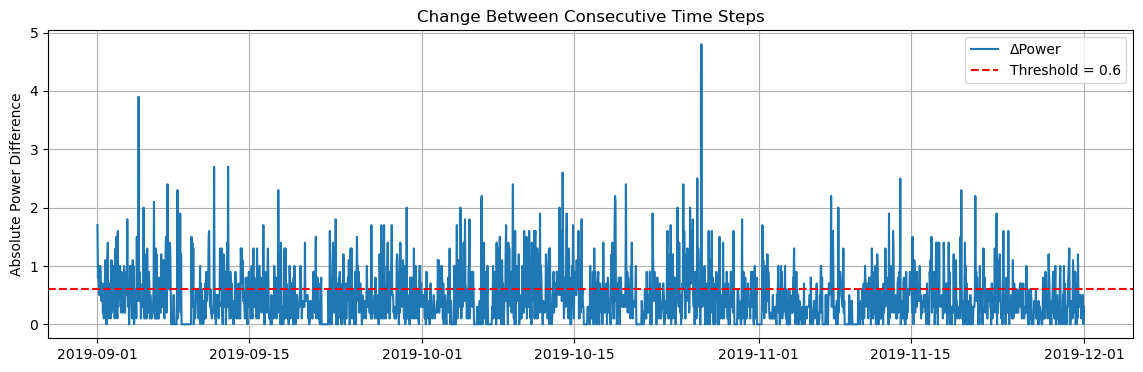

In [171]:
plt.figure(figsize=(14, 4))
plt.plot(diffs.index, diffs, label='ΔPower')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
plt.title("Change Between Consecutive Time Steps")
plt.ylabel("Absolute Power Difference")
plt.legend()
plt.grid(True)
plt.show()